<a href="https://colab.research.google.com/github/Kat-nesh/Redefining-maize-UAI/blob/main/Zone_Delineation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Prerequisites

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from geemap import ml
from sklearn import ensemble
from geemap import ml
from sklearn import ensemble
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
plt.rcParams.update({'figure.figsize': (12.0,8.0)})
plt.rcParams.update({'font.size' : 14})
#test img
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

from IPython.core.magics.execution import Restart
try:
  import geemap
  import ee
  import geopandas
  import math
except Exception as e:
  !pip install geopandas
  !pip install geemap
  Restart()
finally:
  import geemap
  import ee
try:
  ee.Initialize(project='ee-maizeyield')

except Exception as e:
  ee.Authenticate()
  ee.Initialize(project='ee-maizeyield')




In [3]:
  Map = geemap.Map(project='ee-maizeyield')

In [4]:
prod = ee.FeatureCollection("projects/ee-maizeyield/assets/county_maize_yield_2010-18")
AOI = prod.geometry()
# Map.addLayer(AOI)
# Map.centerObject(AOI, zoom=6)


In [5]:
start = ee.Date('2018-04-01');
end   = ee.Date('2018-08-31');
aoi = ee.FeatureCollection("projects/ee-maizeyield/assets/county_maize_yield_2010-18")
orgcarb = ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02").select('b0').clip(aoi)
soilText = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02").select('b0').clip(aoi)
smois = ee.ImageCollection("NASA_USDA/HSL/SMAP_soil_moisture").filterDate(start, end).filterBounds(aoi).select('ssm').mean().clip(aoi)
dem = ee.Image("CGIAR/SRTM90_V4").clip(aoi)
LST = ee.ImageCollection("MODIS/006/MOD11A1").filterBounds(aoi)
sph = ee.Image("ISDASOIL/Africa/v1/ph").select('mean_0_20')
nitrogen = ee.Image("ISDASOIL/Africa/v1/nitrogen_total").clip(aoi).select('mean_0_20');
era5m = ee.ImageCollection("ECMWF/ERA5/MONTHLY").filterDate(start, end).filterBounds(aoi).select('total_precipitation').mean().clip(aoi)
image = ee.Image("users/Prod/CHIRTSmax2018")
table = ee.FeatureCollection("users/Prod/tn_maize_2022")
aluminium = ee.Image("ISDASOIL/Africa/v1/aluminium_extractable").clip(aoi).select('mean_0_20')
subcounties = ee.FeatureCollection("projects/ee-maizeyield/assets/LR_2018_d")
counties = ee.FeatureCollection("projects/ee-maizeyield/assets/LR_18")
zone20 = ee.FeatureCollection("users/Prod/drive-download-20240314T201028Z-001")
bound = ee.FeatureCollection("users/Prod/boundary")

In [6]:
# palettes = require('users/gena/packages:palettes')
# palette = ['d5c36b','b96947','9d3706','ae868f','f86714','46d143','368f20','3e5a14','ffd557','fff72e','ff5a9d','ff005b']
# palette = palettes.crameri.roma[25]
palette = [ '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a',
'#ffff99', '#b15928', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5']

In [7]:
img10 = ee.Image("users/Prod/YieldMaps10to20/Class2010")
img11 = ee.Image("users/Prod/YieldMaps10to20/Class2011")
img12 = ee.Image("users/Prod/YieldMaps10to20/Class2012")
img13 = ee.Image("users/Prod/YieldMaps10to20/Class2013")
img14 = ee.Image("users/Prod/YieldMaps10to20/Class2014")
img15 = ee.Image("users/Prod/YieldMaps10to20/Class2015")
img16 = ee.Image("users/Prod/YieldMaps10to20/Class2016")
img17 = ee.Image("users/Prod/YieldMaps10to20/Class2017")
img18 = ee.Image("users/Prod/YieldMaps10to20/Class2018")
img19 = ee.Image("users/Prod/YieldMaps10to20/Class2019")
img20 = ee.Image("users/Prod/YieldMaps10to20/Class2020")
imgcol  = ee.ImageCollection.fromImages([img10,img11,img12,img13,img14,img15, img16, img17,img18])
imgvar= imgcol.reduce(ee.Reducer.variance()) #Temporal Variance
Map.addLayer(imgvar, {},'Variance')

In [8]:
# Map

In [9]:
#(B) RESAMPLE ALL IMAGES TO A COMMON SCALE
#=========================================================== \

proj = ee.Image(imgvar).projection()
crs_info = proj.getInfo()
# print('CHIRPS CRS', crs_info.crs.getInfo())
rsn2 = nitrogen.projection();

proj1 =  ee.Image(imgvar).projection()
print('Average Variance projection:',  proj1.getInfo())

projRain = era5m.reproject(rsn2)
print('ReProjected ERA5 rsn', projRain.projection().nominalScale().getInfo())

# projGPP = avgpp.reproject(rsn2)
# print('ReProjected GPP rsn', projGPP.projection().nominalScale().getInfo())

# projEVI = avgEvi.reproject(rsn2)
# print('ReProjected EVI rsn', projEVI.projection().nominalScale().getInfo())

projSRTM = dem.reproject(rsn2)
print('ReProjected SRTM rsn', projSRTM.projection().nominalScale().getInfo())

projSMOS = smois.reproject(rsn2)
print('ReProjected SMOS rsn', projSMOS.projection().nominalScale().getInfo())

projPH = sph.reproject(rsn2)
print('ReProjected PH rsn', projPH.projection().nominalScale().getInfo())

projText = soilText.reproject(rsn2)
print('ReProjected Texture rsn', projText.projection().nominalScale().getInfo())

projnitr = nitrogen.reproject(rsn2)
print('ReProjected Nitrogen rsn', projnitr.projection().nominalScale().getInfo())

projCO2 = orgcarb.reproject(rsn2)
print('ReProjected CO2 rsn', projCO2.projection().nominalScale().getInfo())

projalumn = aluminium.reproject(rsn2)
print('ReProjected Aluminium rsn', projalumn.projection().nominalScale().getInfo())

# projPrec = avgprec.reproject(rsn2)
# print('ReProjected ERA5 M rsn', projPrec.projection().nominalScale().getInfo())



Average Variance projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
ReProjected ERA5 rsn 30
ReProjected SRTM rsn 30
ReProjected SMOS rsn 30
ReProjected PH rsn 30
ReProjected Texture rsn 30
ReProjected Nitrogen rsn 30
ReProjected CO2 rsn 30
ReProjected Aluminium rsn 30


In [10]:
# COMBINE/STACK THE IMAGES
#=========================================================== \

input =  ee.ImageCollection.fromImages([projalumn,projPH,projnitr,imgvar,projCO2,projText,projSRTM,projSMOS,img18]) \
.toBands().rename(['Aluminium','PH','Nitrogen','Variance','Organic Carbon','Texture','Elevation','Soil Moisture','Yield'])
input = input.toFloat()

In [ ]:
input

# Make the training dataset

In [11]:
input = input.clip(aoi)

# Make the training dataset.
training = input.sample(**{
  'region': aoi,
  'scale': 30,
  'numPixels': 5000
})

bands = input.bandNames()

## Pairwise Correlation

In [12]:
def func_fnf(i):

  def func_sny(j):
    stats = training.reduceColumns(**{
      'reducer': ee.Reducer.pearsonsCorrelation(),
      'selectors': [i,j]
    })
    bandNames = ee.String(i).cat('_').cat(j)
    return ee.Feature(None, {'correlation': stats.get('correlation'), 'band': bandNames})

  return bands.map(func_sny)


pairwiseCorr = ee.FeatureCollection(bands.map(func_fnf).flatten())


In [13]:
# prompt: plot pairwiseCorr

import pandas as pd
import numpy as np

# Convert the ee.FeatureCollection to a client-side list
pairwiseCorr_list = pairwiseCorr.getInfo()['features']

# Extract correlation and band names
data = []
for feature in pairwiseCorr_list:
    data.append([feature['properties']['band'], feature['properties']['correlation']])

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['band', 'correlation'])

# Split the 'band' column into two separate columns for index and columns
df[['band1', 'band2']] = df['band'].str.split('_', expand=True)

# Pivot the DataFrame using the new columns
df_pivot = df.pivot(index='band1', columns='band2', values='correlation')

# Remove index name 'correlation' to avoid confusion
df_pivot.index.name = None

# Replace NaN values with 0
df_pivot = df_pivot.fillna(0)

KeyboardInterrupt: 

In [ ]:
# Plotting the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(df_pivot, annot=True, cmap='coolwarm', annot_kws={"size": 9})
# plt.title('Pairwise Correlation Matrix')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

## K-Means initialization clustering

In [14]:

# Instantiate the clusterer and train it.
clusterer10 = ee.Clusterer.wekaKMeans(10).train(training)

# Cluster the input using the trained clusterer.
result = input.cluster(clusterer10)
#Majority analysis: Smooth with a mode filter.
mode = result.focal_mode()
# Use erosion and dilation to get rid of small islands.
smooth = result.focal_max(3).focal_min(5).focal_max(3)



In [ ]:
# Display the clusters with random colors.
# palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
# Map.addLayer(mode, { 'min':1, 'max':12, 'palette':palette}, 'Zones-Mode',False)
# Map.addLayer(smooth.clip(aoi), { 'min':1, 'max':12, 'palette':palette}, 'Zones-smooth',False)

In [ ]:
# Map

# Evaluate the Clustering Variables

In [16]:
# prompt: iterate through training and  get the values of properties in a df

import pandas as pd

# Initialize an empty list to store the data
data = []

# Iterate through the training features
for feature in training.getInfo().get('features'):
  properties = feature.get('properties')
  data.append(properties)

# Create a Pandas DataFrame from the data
df = pd.DataFrame(data)


In [17]:
df.head(5)

,Aluminium,Elevation,Nitrogen,Organic Carbon,PH,Soil Moisture,Texture,Variance,Yield
0,55,2210,99,5,57,19.865320,1,0.388133,3.39225
1,54,1290,87,5,61,12.246444,1,0.007160,1.50770
2,56,1648,68,5,57,20.578941,1,0.031378,1.91415
3,57,2049,109,4,61,16.041954,4,0.027712,1.83555
4,50,1717,92,5,57,6.495947,4,0.018893,1.21235


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4936 entries, 0 to 4935
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Aluminium       4936 non-null   int64  
 1   Elevation       4936 non-null   int64  
 2   Nitrogen        4936 non-null   int64  
 3   Organic Carbon  4936 non-null   int64  
 4   PH              4936 non-null   int64  
 5   Soil Moisture   4936 non-null   float64
 6   Texture         4936 non-null   int64  
 7   Variance        4936 non-null   float64
 8   Yield           4936 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 347.2 KB


## PCA

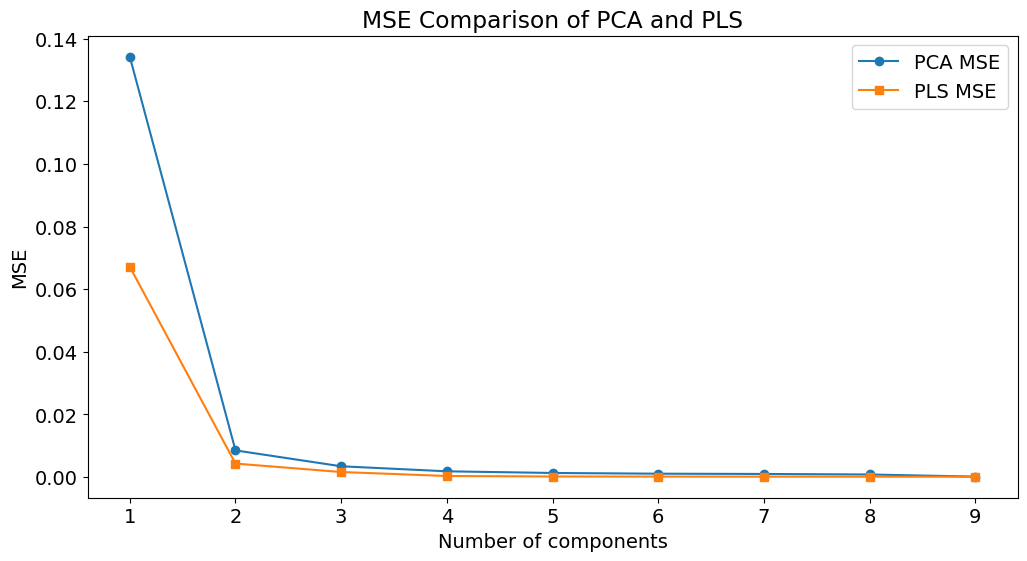

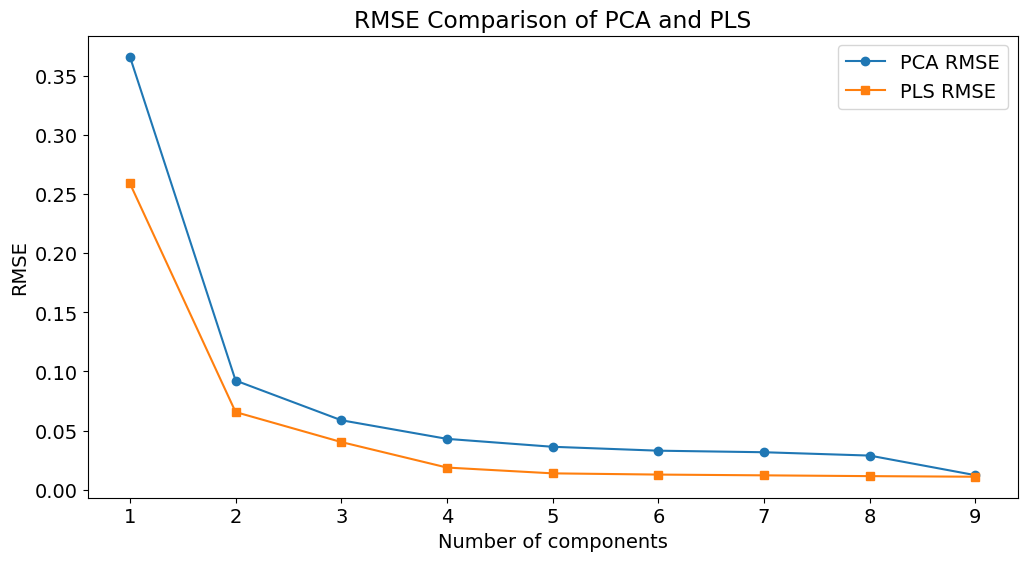

In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
import matplotlib.pyplot as plt

# ... (Data preparation remains the same) ...
X = df
y = df.iloc[:, 8]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit and transform the data

# Define the maximum number of components to consider
max_components = 9

# Train PCA and PLS models for different number of components
pca_mse = []
pca_rmse = []
pls_mse = []
pls_rmse = []

for i in range(1, max_components + 1):
    # Train a PCA model on scaled data
    pca = PCA(n_components=i)
    pca.fit(X_scaled)  # Fit PCA on scaled data
    X_pca = pca.transform(X_scaled)  # Transform scaled data
    xgb = XGBRegressor()
    xgb.fit(X_pca, y)
    y_pred = xgb.predict(X_pca)
    mse = mean_squared_error(y, y_pred)  # Calculate MSE
    pca_mse.append(mse)
    rmse = root_mean_squared_error(y, y_pred)  # Calculate RMSE
    pca_rmse.append(rmse)

    # Train a PLS model on scaled data (optional, you can keep it as before)
    pls = PLSRegression(n_components=i)
    pls.fit(X_scaled, y)  # Fit PLS on scaled data (optional)
    X_pls = pls.transform(X_scaled)  # Transform scaled data (optional)
    xgb = XGBRegressor()
    xgb.fit(X_pls, y)
    y_pred = xgb.predict(X_pls)
    mse = mean_squared_error(y, y_pred)  # Calculate MSE
    pls_mse.append(mse)
    rmse = root_mean_squared_error(y, y_pred)  # Calculate RMSE
    pls_rmse.append(rmse)

# ... (Rest of the code for plotting remains the same) ...
# Plot the results (MSE)
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_components + 1), pca_mse, label='PCA MSE', marker='o')
plt.plot(range(1, max_components + 1), pls_mse, label='PLS MSE', marker='s')
plt.xlabel('Number of components')
plt.ylabel('MSE')
plt.title('MSE Comparison of PCA and PLS')
plt.legend()
# plt.grid(True)
plt.show()

# Plot the results (RMSE)
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_components + 1), pca_rmse, label='PCA RMSE', marker='o')
plt.plot(range(1, max_components + 1), pls_rmse, label='PLS RMSE', marker='s')
plt.xlabel('Number of components')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of PCA and PLS')
plt.legend()
# plt.grid(True)
plt.show()

##Silhouette Score ASC

### Clusters Evaluation

In [34]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming 'df' is your DataFrame
X = df

# Range of clusters to try
range_n_clusters = range(2,100)

# List to store average silhouette scores
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    # Initialize and fit KMeans
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Calculate average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)  # Store the score
    # print(
    #     "For n_clusters =",
    #     n_clusters,
    #     "For cluster labels =",
    #     cluster_labels,
    #     "The average silhouette_score is :",
    #     silhouette_avg,
    # )

# Create the plot of average Silhouette score vs. number of clusters
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(range_n_clusters, silhouette_avg_scores)

# Get the current Axes object and set the x-axis scale
ax = plt.gca()  # Get current axes
ax.set_xscale('log') # Set x-axis scale to logarithmic

plt.xlabel("Number of Clusters (log scale)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.show()

0.5595714923305233
0.5731432889385982
0.5802791703095859
0.5932188817142499
0.5848757434882127
0.5719617118489427
0.568782553793593
0.5466190838754924
0.5398920558222781
0.5429341412365387
0.5303873337018988
0.5117606911650382
0.5093356230498503
0.5151343469958519
0.5127538448231519
0.5037080898210815
0.49612244265503874
0.4911519507565955
0.4874299436961926
0.4905929006372315
0.48280227868297615
0.4751742253460188
0.4723763242335698
0.4657452027012202
0.4720771967887471
0.467428130536887
0.4660320286716152
0.46388872901914857
0.45965283943039226
0.45589042556080983
0.4567802095208298
0.4567194962227619
0.4560349561520008
0.4558936690862775
0.45002979760471373
0.44890492741835375
0.4463365577492947
0.449303320694589
0.43648285151425503
0.43500509458587144
0.43040634304398334
0.428844027194094
0.42736195532145993
0.4267455448127888


KeyboardInterrupt: 

In [40]:
kmeans_final = KMeans(n_clusters=5, random_state=42)
kmeans_final.fit(X_scaled)
data['cluster'] = kmeans_final.labels_


## VRI

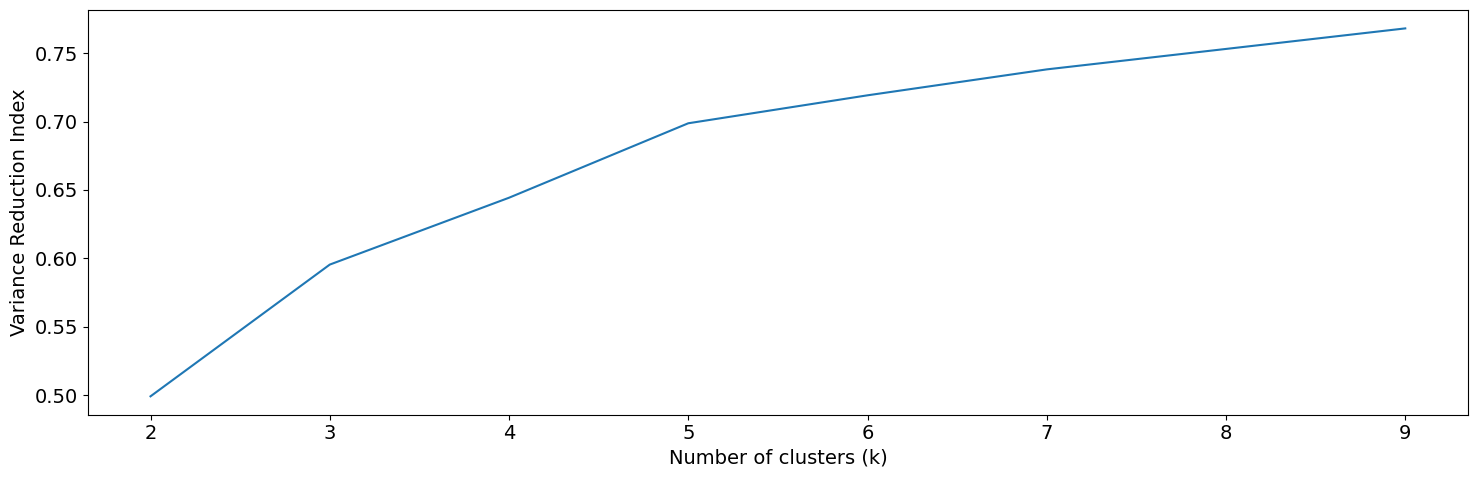

   K  Variance Reduction
0  2            0.499223
1  3            0.595464
2  4            0.644308
3  5            0.698707
4  6            0.719134
5  7            0.738078
6  8            0.753019
7  9            0.768022


In [50]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import numpy as np

# 1. Data Loading & Preparation
# Assuming your data is in a CSV file
data = df

# Select the relevant features for clustering
features =['Aluminium','PH','Nitrogen','Variance','Organic Carbon','Texture','Elevation','Soil Moisture']
X = data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. K-Means Clustering and Metric Calculation
k_range = range(2, 10)  # Range of K values to test
inertia_scores = []
variance_reduction_scores = []

# Calculate total sum of squares (TSS)
tss = ((X_scaled - X_scaled.mean(axis=0))**2).sum()

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)

    # Calculate variance reduction
    variance_reduction = 1 - (kmeans.inertia_ / tss)
    variance_reduction_scores.append(variance_reduction)

# 3. Plot Metrics
plt.figure(figsize=(15, 5))

# plt.subplot(1, 3, 2)
# plt.plot(k_range, inertia_scores, 'bx-')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Inertia (WCSS)')
# plt.title('Elbow Method')

plt.subplot(1, 1, 1)
plt.plot(k_range, variance_reduction_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Variance Reduction Index')
# plt.title('Variance Reduction')

plt.tight_layout()
plt.show()
f_l = []
p_l = []

# 4. Create DataFrame for Metrics
metrics_df = pd.DataFrame({'K': k_range,
                          'Variance Reduction': variance_reduction_scores})

# 5. Display Metrics Table
print(metrics_df)




### Tukey’s test
######  Tukey’s test for the soil variables when the study area was divided into five clusters.

In [48]:
# Select the relevant features for clustering
features =['Aluminium','PH','Nitrogen','Variance','Organic Carbon','Texture','Elevation','Soil Moisture']
# Tukey's HSD Test
for feature in features:
    groups = [data[feature][data['cluster'] == i] for i in range(5)]
    try:
        f_statistic, p_value = f_oneway(*groups)
        print(f"Tukey's HSD for {feature}:")
        print(f"  F-statistic: {f_statistic:.4f}")
        print(f"  p-value: {p_value:.4f}")
        tukeys_df = pd.DataFrame({'feature': feature,
                              'Silhouette': f_statistic,
                                  'Inertia': p_value})
        if p_value < 0.05:
            print("  Significant difference between cluster means.")
        else:
            print("  No significant difference between cluster means.")
    except ValueError:
        print(f"Tukey's HSD cannot be performed for {feature}.")


Tukey's HSD for Aluminium:
  F-statistic: 3763.7035
  p-value: 0.0000
Tukey's HSD cannot be performed for Aluminium.
Tukey's HSD for PH:
  F-statistic: 1145.7258
  p-value: 0.0000
Tukey's HSD cannot be performed for PH.
Tukey's HSD for Nitrogen:
  F-statistic: 3919.9707
  p-value: 0.0000
Tukey's HSD cannot be performed for Nitrogen.
Tukey's HSD for Variance:
  F-statistic: 6492.3654
  p-value: 0.0000
Tukey's HSD cannot be performed for Variance.
Tukey's HSD for Organic Carbon:
  F-statistic: 2700.6562
  p-value: 0.0000
Tukey's HSD cannot be performed for Organic Carbon.
Tukey's HSD for Texture:
  F-statistic: 2003.6159
  p-value: 0.0000
Tukey's HSD cannot be performed for Texture.
Tukey's HSD for Elevation:
  F-statistic: 3009.7583
  p-value: 0.0000
Tukey's HSD cannot be performed for Elevation.
Tukey's HSD for Soil Moisture:
  F-statistic: 3479.4133
  p-value: 0.0000
Tukey's HSD cannot be performed for Soil Moisture.


""
